In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

sys.path.append('../')
import dataio, utils, icnn_pytorch_adaptive as icnn_pytorch, modules

In [18]:
# ckpt_path = '../experiment_scripts/logs/train_new_case_funnel_grad/t_10/checkpoints_dir/model_final.pth'
# model_2 = '../experiment_scripts/logs/train_new_case_funnel_adaptive_scale/t_9/checkpoints_dir/model_final.pth'
#
ckpt_path = '../logs/train_new_case_follow_zero_shallow/t_10/checkpoints_dir/model_final.pth'
model_2 = '../logs/train_new_case_follow_zero_shallow/t_9/checkpoints_dir/model_final.pth'

# ckpt_path = '../logs/train_new_case_funnel_scale/t_10/checkpoints_dir/model_final.pth'
# model_2 = '../logs/train_new_case_funnel_scale/t_9/checkpoints_dir/model_final.pth'

activation = 'relu'

model = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)
# model = modules.SingleBVPNet(in_features=3, out_features=1, type=activation, mode='mlp', hidden_features=32, num_hidden_layers=3, dropout=0)
model2 = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=128, num_hidden_layers=2, dropout=0)

checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
c2 = torch.load(model_2, map_location=torch.device("cpu"))

try:
    model_weights = checkpoint['model']
except:
    model_weights = checkpoint

try:
    mw = c2['model']
except:
    mw = c2

model.load_state_dict(model_weights)
model2.load_state_dict(mw)
model.eval()
model2.eval()

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=1, bias=False)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_yu_u)

In [25]:
## check min max value for t = T - delta t
delta_t = 0.1
V1 = []
t = 0.9
actions = []
values = []
# X = torch.tensor([[t, delta_x, delta_v]], dtype=torch.float32)
for p in torch.linspace(0, 1, 100):
    X = torch.zeros((1, 5))
    X[:, 1] = 0.1
    X[:, 2] = 0.
    X[:, 3] = 0.1
    X[:, 4] = 0.
    p_T = torch.linspace(0, 1, 9).reshape(-1, 1)
    p_T[:, ] = p
    # X[:, 1] = delta_x
    # X[:, 2] = delta_v
    # X_new = torch.from_numpy(utils.dynamics_4d(X, 1, 0.8, DT=delta_t))
    X_new = torch.from_numpy(utils.dynamics_4d_follow_zero(X, 1, 1, DT=delta_t))
    X_new = torch.cat((torch.ones(X_new.shape[0], 1), X_new), dim=1)
    X_new = np.array([utils.make_payoff_zero(X_new[0, :], X_new[1, :], X_new[2, :])]).reshape(-1, 5)
    X_new = torch.from_numpy(X_new.astype(np.float32))
    X = torch.cat((X_new, p_T), dim=1)
    X[:, 0] = t
    X_in = {'coords': X}
    value = model2(X_in)['model_out'].detach().cpu().numpy()
    # value = utils.final_value_minmax((X[:, 1] - X[:, 3]), X[:, -1]).numpy()
    values.append(value)
    minmaxV = value.reshape(3, 3)

    a_idx = np.argmin(np.max(minmaxV, axis=1))
    d_idx = np.argmax(np.min(minmaxV, axis=0))


    V1.append(np.min(np.max(minmaxV, 1)))
    a_choices = [-1, 0, 1]
    actions.append(a_choices[a_idx])

In [26]:
X = torch.zeros((100, 5))
p_T = torch.linspace(0, 1, 100).reshape(-1, 1)

X = torch.cat((X, p_T), dim=1)


# also plot value at next time step
X[:, 0] = 1
X[:, 1] = 0.1
X[:, 2] = 0.
X[:, 3] = 0.1
X[:, 4] = 0.
X_in = {'coords': X}
v2 = model(X_in)['model_out'].detach().cpu().numpy()

In [27]:
from itertools import product

In [28]:
p = p_T.numpy()
points = zip(V1, p)
from utils import cav_vex

In [29]:
ps = np.linspace(0, 1, 100)
vex = []
for p in ps:
    vex.append(cav_vex(V1, p, type='vex', num_ps=100))

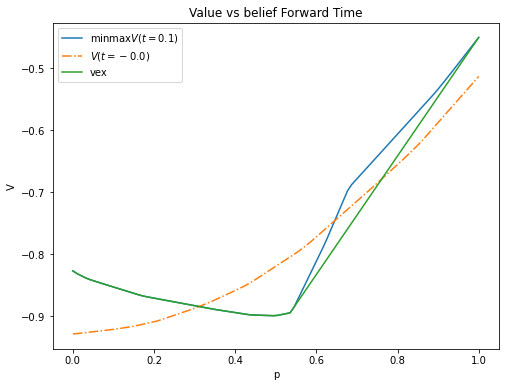

In [30]:
plt.plot(np.linspace(0, 1, 100), V1, label=f'$\min \max V(t={1 - t:.1f})$')
plt.plot(np.linspace(0, 1, 100), v2, '-.', label=f'$V(t={1-t-0.1:.1f})$')
plt.plot(np.linspace(0, 1, 100), vex, label='vex')
plt.title('Value vs belief Forward Time')
plt.xlabel('p')
plt.ylabel('V')
plt.legend()
# plt.ylim([-2, 0])
plt.rcParams['figure.figsize'] = (8, 6)

TEST FOR LAST TWO TIMESTEPS

In [11]:
# ckpt_path = '../experiment_scripts/logs/train_new_case_more_time/t_1/checkpoints_dir/model_final.pth'
# model_2 = '../experiment_scripts/logs/train_new_case_more_time/t_1/checkpoints_dir/model_final.pth'

ckpt_path = '../experiment_scripts/logs/train_new_case_funnel/t_1/checkpoints_dir/model_final.pth'
model_2 = '../experiment_scripts/logs/train_new_case_funnel/t_1/checkpoints_dir/model_final.pth'
activation = 'relu'

model = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=64, num_hidden_layers=3, dropout=0)
# model = modules.SingleBVPNet(in_features=4, out_features=1, type=activation, mode='mlp', hidden_features=64, num_hidden_layers=2, dropout=0)
model2 = icnn_pytorch.SingleBVPNet(in_features=6, out_features=1, type=activation, mode='mlp', hidden_features=64, num_hidden_layers=3, dropout=0)

checkpoint = torch.load(ckpt_path, map_location=torch.device("cpu"))
c2 = torch.load(model_2, map_location=torch.device("cpu"))

try:
    model_weights = checkpoint['model']
except:
    model_weights = checkpoint

try:
    mw = c2['model']
except:
    mw = c2

model.load_state_dict(model_weights)
model2.load_state_dict(mw)
model.eval()
model2.eval()

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        

SingleBVPNet(
  (net): FCBlock(
    (nl): ReLU(inplace=True)
    (net_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=5, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_zu_u): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Dropout(p=0, inplace=False)
      )
    )
    (net_z_zu): ModuleList(
      (0): Sequential(
        

In [12]:
## check min max value for t = T - delta t
delta_t = 0.1
delta_x = 0
delta_v = 0
V1 = []
t = 0.1
actions = []
values = []
# X = torch.tensor([[t, delta_x, delta_v]], dtype=torch.float32)
for p in torch.linspace(0, 1, 100):
    X = torch.zeros((1, 5))
    X[:, 1] = 0
    X[:, 2] = 0
    X[:, 3] = 0
    X[:, 4] = 0
    p_T = torch.linspace(0, 1, 4).reshape(-1, 1)
    p_T[:, ] = p
    X_new = torch.from_numpy(utils.dynamics_4d_follow(X, 1, 1, DT=delta_t))
    X_new = torch.cat((torch.ones(X_new.shape[0], 1), X_new), dim=1)
    X_new = np.array([utils.make_payoff(X_new[0, :], X_new[1, :])]).reshape(-1, X_new.shape[1])
    X_new = torch.from_numpy(X_new.astype(np.float32))
    X = torch.cat((X_new, p_T), dim=1)
    X[:, 0] = t
    X_in = {'coords': X}
    # value = model2(X_in)['model_out'].detach().cpu().numpy()
    value = utils.final_value_minmax((X[:, 1] - X[:, 3]), X[:, -1]).numpy()
    values.append(value)
    minmaxV = value.reshape(2, 2)

    a_idx = np.argmin(np.max(minmaxV, axis=1))
    d_idx = np.argmax(np.min(minmaxV, axis=0))

    V1.append(np.min(np.max(minmaxV, 1)))
    a_choices = [-1, 1]
    actions.append(a_choices[a_idx])

In [13]:
X = torch.zeros((100, 5))
p_T = torch.linspace(0, 1, 100).reshape(-1, 1)

X = torch.cat((X, p_T), dim=1)


# also plot value at t = 0.5
X[:, 0] = 0.1
X[:, 1] = 0.0
X[:, 2] = 0.0
X[:, 3] = 0.0
X[:, 4] = 0.0
X_in = {'coords': X}
v2 = model(X_in)['model_out'].detach().cpu().numpy()

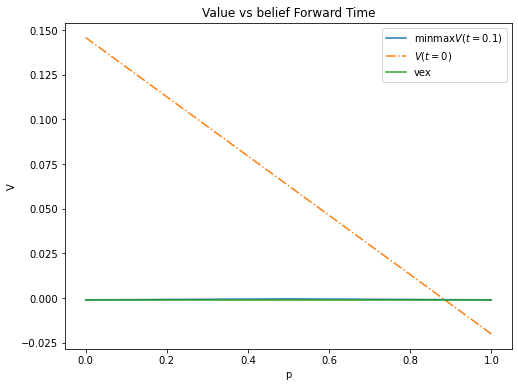

In [14]:
p = p_T.numpy()
points = zip(V1, p)
from utils import cav_vex

ps = np.linspace(0, 1, 100)
vex = []
for p in ps:
    vex.append(cav_vex(V1, p, type='vex', num_ps=100))
plt.plot(np.linspace(0, 1, 100), V1, label='$\min \max V(t=0.1)$')
plt.plot(np.linspace(0, 1, 100), v2, '-.', label='$V(t=0)$')
plt.plot(np.linspace(0, 1, 100), vex, label='vex')
plt.title('Value vs belief Forward Time')
plt.xlabel('p')
plt.ylabel('V')
plt.legend()
# plt.ylim([-0.004, 0.00])
plt.rcParams['figure.figsize'] = (8, 6)

In [10]:
import scipy.io as scio

In [11]:
data = scio.loadmat('../new_case_data_follow_zero_sig/train_data_t_1.0.mat')

In [12]:
x1 = data['states'][:, 1]
p = data['states'][:, -1]
v = data['values']

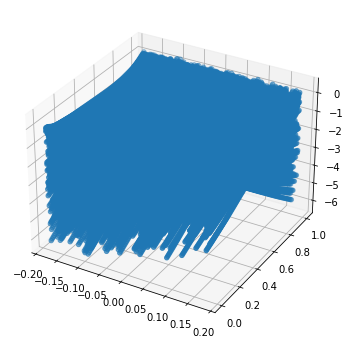

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, p, v)
plt.show()

In [14]:
import pandas as pd

In [15]:
states = data['states']
values = data['values']

In [16]:
gt = np.hstack((states, values))

In [17]:
df = pd.DataFrame(gt)

In [18]:
cols = ['t', 'x1', 'v1', 'x2', 'v2', 'p', 'value']
df.columns = cols

In [19]:
df

,t,x1,v1,x2,v2,p,value
0,1.0,1.349299e-02,-0.105280,0.105912,-0.108158,0.000000,-0.127141
1,1.0,1.349299e-02,-0.105280,0.105912,-0.108158,0.010101,-0.138550
2,1.0,1.349299e-02,-0.105280,0.105912,-0.108158,0.020202,-0.149959
3,1.0,1.349299e-02,-0.105280,0.105912,-0.108158,0.030303,-0.161367
4,1.0,1.349299e-02,-0.105280,0.105912,-0.108158,0.040404,-0.172776
...,...,...,...,...,...,...,...
799995,1.0,7.237196e-07,-0.000703,0.000617,0.000486,0.959596,-0.328883
799996,1.0,7.237196e-07,-0.000703,0.000617,0.000486,0.969697,-0.318080
799997,1.0,7.237196e-07,-0.000703,0.000617,0.000486,0.979798,-0.307276
799998,1.0,7.237196e-07,-0.000703,0.000617,0.000486,0.989899,-0.296472


In [20]:
d = df['x1'] - df['x2']
v = df['value']

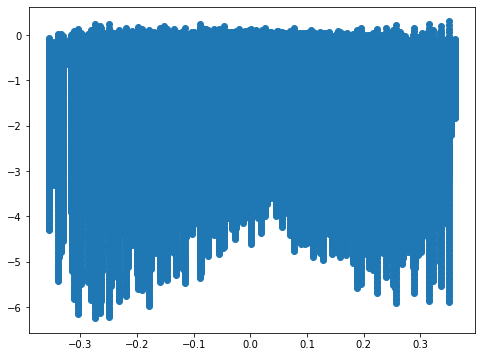

In [21]:
plt.scatter(d, v)

0        -0.092419
1        -0.092419
2        -0.092419
3        -0.092419
4        -0.092419
            ...   
799995   -0.000616
799996   -0.000616
799997   -0.000616
799998   -0.000616
799999   -0.000616
Length: 800000, dtype: float64